### Heston Model

The Heston model describes the evolution of a stock price $S_t$ whose variance $V_t$ is given by a mean reverting square root process:

\begin{eqnarray}
\frac{dS_t}{S_t} &=& \mu dt  + \sqrt{V_t}dW_t^{1},\\
dV_t &=& \kappa(\theta - V_t)dt  + \sigma \sqrt{V_t}dW_t^{2}.
\end{eqnarray}

A key characteristic of the model is that the Wiener processes are correlated $dW_t^{1}\cdot dW_t^{2}=\rho dt$. This feature enables the model to exhibit the 'leverage effect'. 

### Jump Diffusion Models: Bates Method

The Bates Jump-Diffusion model [BATES1993] is specified as the following set of coupled stochastic differential equations

\begin{equation}
\frac{dS_t}{S_t} = \mu dt  + \sqrt{V_t}dW_t^{1} + (Y-1)S_tdN_t,
\end{equation}
\begin{equation}
dV_t = \kappa(\theta - V_t)dt  + \sigma \sqrt{V_t}dW_t^{2},
\end{equation}

describing the evolution of a stock price $S_t$ whose variance $V_t$ is given by a mean reverting square root process which ensures that the variance is always positive provided that $2\kappa\theta - \sigma^2>0$. $N_t$ is a standard Poisson process with intensity $\lambda>0$ and $Y$ is the log-normal jump size distribution with mean $\mu_j=ln (1+a) - \frac{\sigma_j^2}{2},~a>-1$ and standard deviation $\sigma_j \geq 0$. 

Both $N(t)$ and $Y$ are independent of the Wiener processes $W_t^{1}$ and $W_t^{2}$.  A key characteristic of the model, which originates from the embedded Heston stochastic volatility diffusion model, is that the Wiener processes are correlated $dW_t^{1}\cdot dW_t^{2}=\rho dt$. This feature enables the model to exhibit the leverage effect. Note that simply excluding the compound Poisson term $(Y-1)S_tdN_t$ recovers the Heston model.

## Pricing
With marginal loss of generality, we will restrict the scope of this section to European equity options. Stochastic volatility models permit semi-analytical closed-form solutions for computing risk neutral European option prices. The price can be represented as a weighted sum of the delta of the European call option $P_1$ and $P_2$ - the probability that the asset price will
exceed the strike price at maturity. Adopting standard option pricing notation, the call price of a vanilla European option is

\begin{equation}
 C(S_0, K,\tau; \mathbf{z}_0) = S_0P_1 - K\exp\{-(r-q )\tau\}P_2,
\end{equation}

$P_1$ and $P_2$ can be expressed as:

\begin{equation}
P_j =\frac{1}{2} + \frac{1}{\pi} \int_{o}^{\infty} \text{Re}\left[\frac{\exp\{-iu ln K\}\phi_j (S_0,\tau,u; \mathbf{z}_0)}{iu}\right]du, j=1,2.
\end{equation}

where $\phi_j$ are Heston analytic characteristic functions and $\mathbf{z}_0$ is the vector of Heston model parameters.  

### Fourier-Cosine Method
An alternative approach to the Carr-Madan FFT approach is to use the Fourier-Cosine Method. Following Fang and Oosterlee [FANG2008], the entire inverse Fourier integral in the pricing equation is reconstructed from Fourier-cosine series expansion of the integrand to give the following approximation of the call price
\begin{equation}
C(S_0, K, \tau; \mathbf{z}_0) \approx Ke^{-r\tau} \cdot \text{Re}\{\sum_{k=0}^{N-1}'\phi\left(\frac{k\pi}{b-a};\mathbf{z}_0\right)e^{ik\pi\frac{x - a}{b-a}}U_k\},
\end{equation}
where $x:= ln(S_0/K)$ and $\phi(w;\mathbf{z}_0)$ denotes the characteristic function of the log-asset price, $U_k$ the payoff series coefficients and $N$ denotes the number of terms in the cosine series expansion (typically 128 will suffice). 

For the approximation of the Heston model call price, the Fourier-Cosine approach is shown to be superior in convergence properties to other FFT and quadrature based methods in [DIXON2013].


<img src="error_convergence.png">

In [7]:
from random import Random
from numpy import *
from scipy import *
from time import *
from datetime import *
import numpy as np
import sys
import csv

%matplotlib inline

In [8]:
### Implement the Fourier-Cosine Method
def HestonCOS(S,K,T,r,sigma,lmbda,meanV,v0,rho, otype, N=256):
    c1 = r*T+(1-exp(-lmbda*T))*(meanV-v0)/(2.0*lmbda)-0.5*meanV*T
    c2 = 1.0/(8.0*lmbda**3)*(sigma*T*lmbda*exp(-lmbda*T)*(v0-meanV)*(8.0*lmbda*rho-4.0*sigma)+lmbda*rho*sigma*(1-exp(-lmbda*T))*(16.0*meanV-8.0*v0)+2.0*meanV*lmbda*T*(-4.0*lmbda*rho*sigma+sigma**2+4.0*lmbda**2)+sigma**2*((meanV-2.0*v0)*exp(-2.0*lmbda*T)+meanV*(6.0*exp(-lmbda*T)-7.0)+2.0*v0)+8.0*lmbda**2*(v0-meanV)*(1-exp(-lmbda*T)))
    a = c1-12.0*sqrt(abs(c2))
    b = c1+12.0*sqrt(abs(c2))
    x = log(float(S)/K)
    k = arange(0,N)
    if (otype == 'C'):
       U = 2.0/(b-a)*(xi(k,a,b,0,b) - psi(k,a,b,0,b))
    else:
       U = 2.0/(b-a)*(-xi(k,a,b,a,0) + psi(k,a,b,a,0))   
    unit = [1.0] * N
    unit[0] = 0.5
    ret = 0
# Note that HestonCF is independent of the strike
    HCF = HestonCF(k*pi/(b-a),T,r,sigma,lmbda,meanV,v0,rho)
    for i in range(N):
      ret += unit[i]*HCF[i]*exp(1j*float(k[i])*pi*(x-a)/(b-a))*U[i]
    return K*exp(-r*T)*ret.real

def HestonVega(S,K,T,r,sigma,lmbda,meanV,v0,rho, otype, N=256):
    c1 = r*T+(1-exp(-lmbda*T))*(meanV-v0)/(2.0*lmbda)-0.5*meanV*T
    c2 = 1.0/(8.0*lmbda**3)*(sigma*T*lmbda*exp(-lmbda*T)*(v0-meanV)*(8.0*lmbda*rho-4.0*sigma)+lmbda*rho*sigma*(1-exp(-lmbda*T))*(16.0*meanV-8.0*v0)+2.0*meanV*lmbda*T*(-4.0*lmbda*rho*sigma+sigma**2+4.0*lmbda**2)+sigma**2*((meanV-2.0*v0)*exp(-2.0*lmbda*T)+meanV*(6.0*exp(-lmbda*T)-7.0)+2.0*v0)+8.0*lmbda**2*(v0-meanV)*(1-exp(-lmbda*T)))
    a = c1-12.0*sqrt(abs(c2))
    b = c1+12.0*sqrt(abs(c2))
    x = log(float(S)/K)
    k = arange(0,N)
    if (otype == 'C'):
       U = 2.0/(b-a)*(xi(k,a,b,0,b) - psi(k,a,b,0,b))
    else:
       U = 2.0/(b-a)*(-xi(k,a,b,a,0) + psi(k,a,b,a,0))   
    unit = [1.0] * N
    unit[0] = 0.5
    ret = 0
# Note that HestonCF is independent of the strike
    HCF = HestonCFdu0(k*pi/(b-a),T,r,sigma,lmbda,meanV,v0,rho)
    for i in range(N):
      ret += unit[i]*HCF[i]*exp(1j*float(k[i])*pi*(x-a)/(b-a))*U[i]
    return K*exp(-r*T)*ret.real


def HestonCF(u,T,r,sigma,lmbda,meanV,v0,rho):
    a = lmbda*meanV
    b = lmbda
    d = sqrt((1j*rho*sigma*u-b)**2+(u**2+1j*u)*sigma**2)
    g = (b-1j*rho*sigma*u-d)/(b-1j*rho*sigma*u+d)
    ret = exp(1j*u*r*T)
    ret = ret*exp((a/sigma**2)*((b - rho*1j*sigma*u - d)*T - 2.0*log((1-g*exp(-d*T))/(1-g))))
    return ret*exp((v0/sigma**2)*(b - rho*1j*sigma*u - d)*(1-exp(-d*T))/(1-g*exp(-d*T)))


# The Derivative of the Heston Characteristic Function w.r.t. to the v0 
def HestonCFdu0(u,T,r,sigma,lmbda,meanV,v0,rho):

    a = lmbda*meanV
    b = lmbda
    d = sqrt((1j*rho*sigma*u-b)**2+(u**2+1j*u)*sigma**2)
    g = (b-1j*rho*sigma*u-d)/(b-1j*rho*sigma*u+d)
    ret = exp(1j*u*r*T)
    
    ret = ret*exp((a/sigma**2)*((b - rho*1j*sigma*u - d)*T - 2.0*log((1.0-g*exp(-d*T))/(1.0-g))))
    ret = ret*exp((v0/sigma**2)*(b - rho*1j*sigma*u - d)*(1.0-exp(-d*T))/(1.0-g*exp(-d*T)))
    ret = ret *((1.0-exp(-d*T))/(1.0-g*exp(-d*T)))*(b-1j*rho*sigma*u-d)/(sigma**2)
    return(ret)



def xi(k,a,b,c,d):
    ret = 1.0/(1+(k*pi/(b-a))**2)*(cos(k*pi*(d-a)/(b-a))*exp(d)-cos(k*pi*(c-a)/(b-a))*exp(c)+k*pi/(b-a)*sin(k*pi*(d-a)/(b-a))*exp(d)-k*pi/(b-a)*sin(k*pi*(c-a)/(b-a))*exp(c))
    return ret

def psi(k,a,b,c,d):
    N = len(k)
    idx = arange(1, N)
    ret = array([0.0]*N)
    ret[0] = d-c
    ret[idx] =(sin(k[idx]*pi*(d-a)/(b-a))-sin(k[idx]*pi*(c-a)/(b-a)))*(b-a)/(k[idx]*pi)
    return ret



In [615]:
import matplotlib.pyplot as plt

In [12]:
nInt = 256
r0 = 0.0002

#p0 = [5.76145232379, 0.393696857573, 0.99999999,-0.686387364593,0.685888435264]
#print Error_Function(p0)

S= 100
K = 100
T = 0.01
r = r0
sigma = 0.6
lmbda = 0.1
meanV = 0.1
v0 = 0.1
rho =-0.9
V= HestonCOS(S,K,T,r,sigma,lmbda,meanV,v0,rho, 'C', N=nInt)

vegas = []
S_arr = np.arange(90,110,0.1)
for S in S_arr:
  vegas.append(HestonVega(S,K,T,r,sigma,lmbda,meanV,v0,rho, 'C', N=nInt));


Text(0,0.5,'vegas')

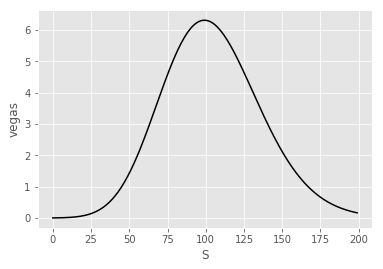

In [584]:
plt.figure(facecolor='white', edgecolor='black')
plt.grid(True)
plt.plot(vegas, color='black')
plt.xlabel('S')
plt.ylabel('vegas')

What if we just fit the regression to a smaller number of points

In [7]:
idx = np.arange(1,len(S_arr),40)

In [8]:
rg = np.polyfit(S_arr[idx], np.array(vegas)[idx], 4)
vegas_reg = np.polyval(rg, S_arr[idx])  # continuation values

Text(0,0.5,'vegas')

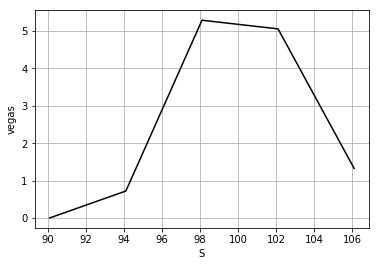

In [9]:
plt.figure(facecolor='white', edgecolor='black')
plt.grid(True)
plt.plot(S_arr[idx], vegas_reg, color='black')
plt.xlabel('S')
plt.ylabel('vegas')

What if I fit polynomial regression

In [10]:
x = S_arr[idx]
y = np.array(vegas)[idx]
p3=np.polyfit(x, y, 3)
p3_test = np.polyval(np.polyfit(x, y, 3), x)

In [11]:
def p3_func(x):
    ret = p3[0] * (x**3) + p3[1] * (x**2) + p3[2] * x + p3[3]
    return ret

In [12]:
poly_reg = []
for S in S_arr[idx]:
    poly_reg.append(p3_func(S))

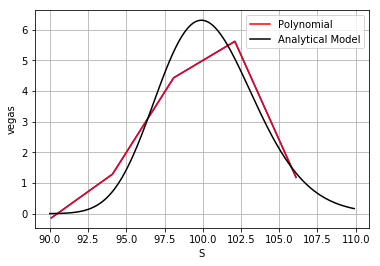

In [13]:
plt.figure(facecolor='white', edgecolor='black')
plt.plot(S_arr[idx], poly_reg, color='b') # calculated by p3_func above, overlapped with plot by np.polyval(...), same result.
plt.plot(S_arr[idx], p3_test, color = 'r', label = 'Polynomial') # calculated by np.polyval(...)
plt.plot(S_arr, vegas, color = 'black', label = 'Analytical Model') 
plt.xlabel('S')
plt.ylabel('vegas')
plt.grid(True)
plt.legend(loc = 'best', prop={'size':10})

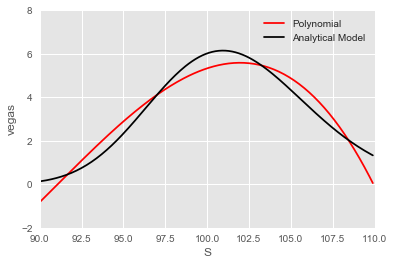

In [13]:
# tweak parameters
S_t= 100
K_t = 101
T_t = 0.014
r_t = r0
sigma_t = 0.5
lmbda_t = 0.1
meanV_t = 0.1
v0_t = 0.15
rho_t =-0.9
V_t= HestonCOS(S_t, K_t, T_t, r_t, sigma_t, lmbda_t, meanV_t, v0_t, rho_t, 'C', N=nInt)

vegas_tweak = []
S_arr = np.arange(90,110,0.1)
for S in S_arr:
    vegas_tweak.append(HestonVega(S, K_t, T_t, r_t, sigma_t, lmbda_t, meanV_t, v0_t, rho_t, 'C', N=nInt));

p3_tweak = np.polyval(np.polyfit(S_arr, np.array(vegas_tweak), 3), S_arr)

plt.figure(facecolor='white', edgecolor='black')
plt.grid(True)
plt.xlim(90, 110)
plt.xlabel('S')
plt.ylabel('vegas')
plt.plot(S_arr, p3_tweak, color='red', label = 'Polynomial')
plt.plot(S_arr, vegas_tweak, color = 'black', label = 'Analytical Model')
plt.ylim(-2,8)
plt.legend(loc = 'best', prop={'size':10})

# Apply GPR

In [1]:
import os
os.environ['TF_C_API_GRAPH_CONSTRUCTION']='0'
import tensorflow as tf
import edward as ed
import matplotlib.pyplot as plt
import numpy as np
from edward.models import Normal
import seaborn as sns
plt.style.use('ggplot')
from edward.models import MultivariateNormalTriL
from edward.util import rbf
from scipy.optimize import minimize

/Users/matthewdixon/anaconda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Define functions and set up data

In [2]:
def llk(x):
    l = np.float(x[0])
    noise_term = np.float(x[1])
    #print l, noise_term
    Kernel = rbf(train_x, lengthscale=l).eval()
    K_y = Kernel + np.eye(training_number) * noise_term 
    L = np.linalg.cholesky(K_y)
    K_y_inv = np.linalg.inv(K_y)
    v_y= np.matmul(K_y_inv,train_y) 
    D= np.linalg.det(K_y)
    if abs(D)< 1e-10:
        D= 1e-10
    ret = - 0.5*np.dot(v_y.T, v_y) - 0.5*np.log(np.linalg.det(K_y)) -(training_number/2.0)*np.log(2.0*np.pi)
    
    return(-ret)

In [37]:
def llk2(x):
    l = np.float(x[0])
    noise_term = np.float(x[1])
    #print l, noise_term
    Kernel = rbf(train_x, lengthscale=l).eval()
    K_y = Kernel + np.eye(training_number) * noise_term 
    L = scipy.linalg.cho_factor(K_y)
    alpha = scipy.linalg.cho_solve(L, train_y)
    LF= np.linalg.cholesky(K_y)   
    LL = np.log(np.diag(LF))
    ret = - 0.5*np.dot(np.array(train_y).T, alpha) -np.sum(LL) -(training_number/2.0)*np.log(2.0*np.pi)
    print ret  

In [39]:
bounds=[ [0.001,1.0],[0.001,0.1]   ]

#construct the bounds in the form of constraints
cons = []
for factor in range(len(bounds)):
    lower, upper = bounds[factor]
    l = {'type': 'ineq',
         'fun': lambda x, lb=lower, i=factor: x[i] - lb}
    u = {'type': 'ineq',
         'fun': lambda x, ub=upper, i=factor: ub - x[i]}
    cons.append(l)
    cons.append(u)

# Data Generation Process

In [41]:
# Numerical prediction
sess = ed.get_session()
training_number = 50    # You can change the number to see training quality with different amount of training dataset 
train_x = np.array(np.linspace(90,110, training_number), dtype='float32').reshape(training_number, 1)
train_y = []
for S in train_x:
    train_y.append(HestonVega(S,K,T,r,sigma,lmbda,meanV,v0,rho, 'C', N=nInt))

testing_number = 100
test_x = np.array(np.linspace(90,110, testing_number), dtype='float32').reshape(testing_number, 1)
test_y = []
for S in test_x:
    test_y.append(HestonVega(S,K,T,r,sigma,lmbda,meanV,v0,rho, 'C', N=nInt))

# Tuning

In [40]:
x0 =[0.1, 0.01] # initial value
res = minimize(llk2, x0, method='COBYLA', constraints=cons, options={'gtol': 1e-16, 'disp': True})
res

/Users/matthewdixon/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: OptimizeWarning: Unknown solver options: gtol
  


-123.43731730907469
-53.23995715386687
-78.10073170063117
-123.43373903976597
-113.04477450365971
-123.43731730907469
-121.99182541879874
-123.43731730907469
-123.25405979995061
-123.43731730907469
-123.41436932629648
-123.43731730907469
-123.43261661129652


     fun: 6.9532188964098e-310
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 13
  status: 1
 success: True
       x: array([0.1 , 0.01])

In [514]:
l = np.float(res.x[0])
noise_term = np.float(res.x[1])

Kernel = rbf(train_x, lengthscale=l).eval()
K_noise = Kernel + np.eye(training_number) * noise_term  # without noise, the cov band converge to 0 at the training points 
k_s = rbf(test_x, train_x).eval()                   
L = np.linalg.cholesky(K_noise)
alpha = np.linalg.solve(L.T, np.linalg.solve(L, train_y))
predict_mean = np.dot(k_s, alpha)

# cov
v = np.linalg.solve(L, k_s.T)
var = rbf(test_x).eval() - np.dot(v.T, v)

For comparison, see how polyfit works by fitting to training data

In [516]:
coeff=np.polyfit(train_x.flatten(), train_y, 3)
y_poly = np.polyval(coeff, test_x) ## evaluate on test

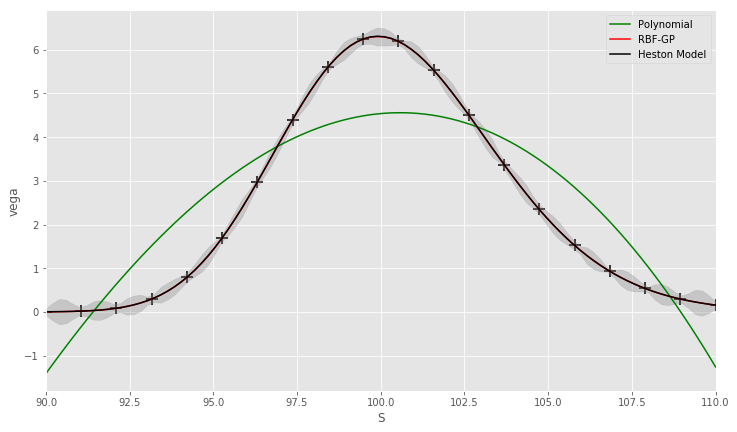

In [517]:
# plot with cov band
up = predict_mean - 2 * (np.sqrt(np.diag(var)))   # 95% confident interval 
down = predict_mean + 2 * (np.sqrt(np.diag(var)))

plt.figure(figsize = (12, 7), facecolor='white', edgecolor='black')
plt.grid(True)
plt.xlim(90, 110)
plt.xlabel('S')
plt.ylabel('vega')
plt.plot(test_x, y_poly, color = 'g', label = 'Polynomial')
plt.plot(test_x, predict_mean, color = 'red', label = 'RBF-GP')
plt.plot(test_x, test_y, color = 'black', label = 'Heston Model')
plt.scatter(train_x, train_y, s = 150, color = 'black', marker = "+")
plt.fill_between(test_x.flatten(), up, down, color = 'grey', alpha=0.3)
plt.legend(loc = 'best', prop={'size':10})

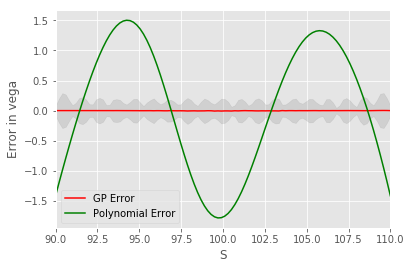

In [228]:
# plot with cov band 
up = predict_mean - 2 * (np.sqrt(np.diag(var)))   # 95% confident interval 
down = predict_mean + 2 * (np.sqrt(np.diag(var)))

plt.figure(facecolor='white', edgecolor='black')
plt.plot(test_x, predict_mean-test_y, color = 'red', label = 'GP Error')
plt.plot(test_x, y_poly.flatten()-test_y, color = 'green', label = 'Polynomial Error')
#plt.plot(train_x, train_y, color = 'black', label = 'Analytical Model')
#plt.scatter(test_x, test_y, s = 150, color = 'black', marker = "+")
plt.fill_between(test_x.flatten(), up-test_y, down - test_y, color = 'grey', alpha=0.2)
plt.grid(True)
plt.xlim(90, 110)
plt.xlabel('S')
plt.ylabel('Error in vega')
plt.legend(loc = 'best', prop={'size':10})

# Convergence study

In [418]:
# Convergency check with multiple training sets
mse = []
params = []

In [668]:
training_number = 30   # change training size 
train_x = np.array(np.linspace(90,110, training_number), dtype='float32').reshape(training_number, 1)
train_y = []
for S in train_x:
    train_y.append(HestonVega(S,K,T,r,sigma,lmbda,meanV,v0,rho, 'C', N=nInt))
    
testing_number = 100
test_x = np.array(np.linspace(90,110, testing_number), dtype='float32').reshape(testing_number, 1)
test_y = []
for S in test_x:
    test_y.append(HestonVega(S,K,T,r,sigma,lmbda,meanV,v0,rho, 'C', N=nInt))

In [670]:
x0 =[0.1, 0.01] # initial value
bounds=[ [0.001, 1.0], [0.001, 0.1]]     #construct the bounds in the form of constraints
cons = []
for factor in range(len(bounds)):
    lower, upper = bounds[factor]
    l = {'type': 'ineq',
         'fun': lambda x, lb=lower, i=factor: x[i] - lb}
    u = {'type': 'ineq',
         'fun': lambda x, ub=upper, i=factor: ub - x[i]}
    cons.append(l)
    cons.append(u)
    
    
res = minimize(llk, x0, method='COBYLA', constraints=cons, options={'gtol': 1e-16, 'disp': True})
res

/Users/jinxiwen/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:14: OptimizeWarning: Unknown solver options: gtol
  
/Users/jinxiwen/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log
  if sys.path[0] == '':


InvalidArgumentError: assertion failed: [] [Condition x > 0 did not hold element-wise:] [x (Const_5786:0) = ] [nan]
	 [[Node: assert_positive_3810/assert_less/Assert/AssertGuard/Assert = Assert[T=[DT_STRING, DT_STRING, DT_STRING, DT_FLOAT], summarize=3, _device="/job:localhost/replica:0/task:0/device:CPU:0"](assert_positive_3810/assert_less/Assert/AssertGuard/Assert/Switch, assert_positive_3810/assert_less/Assert/AssertGuard/Assert/data_0, assert_positive_3810/assert_less/Assert/AssertGuard/Assert/data_1, assert_positive_3810/assert_less/Assert/AssertGuard/Assert/data_2, assert_positive_3810/assert_less/Assert/AssertGuard/Assert/Switch_1)]]

Caused by op u'assert_positive_3810/assert_less/Assert/AssertGuard/Assert', defined at:
  File "/Users/jinxiwen/anaconda3/envs/py27/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/Users/jinxiwen/anaconda3/envs/py27/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/jinxiwen/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/jinxiwen/anaconda3/envs/py27/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/jinxiwen/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/Users/jinxiwen/anaconda3/envs/py27/lib/python2.7/site-packages/tornado/ioloop.py", line 1064, in start
    handler_func(fd_obj, events)
  File "/Users/jinxiwen/anaconda3/envs/py27/lib/python2.7/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/jinxiwen/anaconda3/envs/py27/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/Users/jinxiwen/anaconda3/envs/py27/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/jinxiwen/anaconda3/envs/py27/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/Users/jinxiwen/anaconda3/envs/py27/lib/python2.7/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/jinxiwen/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/jinxiwen/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/jinxiwen/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/jinxiwen/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/jinxiwen/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/jinxiwen/anaconda3/envs/py27/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2714, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/jinxiwen/anaconda3/envs/py27/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2818, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/jinxiwen/anaconda3/envs/py27/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2878, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-670-eac84dc6880b>", line 14, in <module>
    res = minimize(llk, x0, method='COBYLA', constraints=cons, options={'gtol': 1e-16, 'disp': True})
  File "/Users/jinxiwen/anaconda3/envs/py27/lib/python2.7/site-packages/scipy/optimize/_minimize.py", line 608, in minimize
    return _minimize_cobyla(fun, x0, args, constraints, **options)
  File "/Users/jinxiwen/anaconda3/envs/py27/lib/python2.7/site-packages/scipy/optimize/cobyla.py", line 252, in _minimize_cobyla
    dinfo=info)
  File "/Users/jinxiwen/anaconda3/envs/py27/lib/python2.7/site-packages/scipy/optimize/cobyla.py", line 242, in calcfc
    f = fun(x, *args)
  File "<ipython-input-667-f1b544eca741>", line 5, in llk
    Kernel = rbf(train_x, lengthscale=l).eval()
  File "/Users/jinxiwen/anaconda3/envs/py27/lib/python2.7/site-packages/edward/util/tensorflow.py", line 82, in rbf
    dependencies = [tf.assert_positive(lengthscale),
  File "/Users/jinxiwen/anaconda3/envs/py27/lib/python2.7/site-packages/tensorflow/python/ops/check_ops.py", line 221, in assert_positive
    return assert_less(zero, x, data=data, summarize=summarize)
  File "/Users/jinxiwen/anaconda3/envs/py27/lib/python2.7/site-packages/tensorflow/python/ops/check_ops.py", line 582, in assert_less
    return control_flow_ops.Assert(condition, data, summarize=summarize)
  File "/Users/jinxiwen/anaconda3/envs/py27/lib/python2.7/site-packages/tensorflow/python/util/tf_should_use.py", line 118, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs))
  File "/Users/jinxiwen/anaconda3/envs/py27/lib/python2.7/site-packages/tensorflow/python/ops/control_flow_ops.py", line 180, in Assert
    guarded_assert = cond(condition, no_op, true_assert, name="AssertGuard")
  File "/Users/jinxiwen/anaconda3/envs/py27/lib/python2.7/site-packages/tensorflow/python/util/deprecation.py", line 432, in new_func
    return func(*args, **kwargs)
  File "/Users/jinxiwen/anaconda3/envs/py27/lib/python2.7/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2072, in cond
    orig_res_f, res_f = context_f.BuildCondBranch(false_fn)
  File "/Users/jinxiwen/anaconda3/envs/py27/lib/python2.7/site-packages/tensorflow/python/ops/control_flow_ops.py", line 1913, in BuildCondBranch
    original_result = fn()
  File "/Users/jinxiwen/anaconda3/envs/py27/lib/python2.7/site-packages/tensorflow/python/ops/control_flow_ops.py", line 178, in true_assert
    condition, data, summarize, name="Assert")
  File "/Users/jinxiwen/anaconda3/envs/py27/lib/python2.7/site-packages/tensorflow/python/ops/gen_logging_ops.py", line 51, in _assert
    name=name)
  File "/Users/jinxiwen/anaconda3/envs/py27/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/Users/jinxiwen/anaconda3/envs/py27/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 3392, in create_op
    op_def=op_def)
  File "/Users/jinxiwen/anaconda3/envs/py27/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): assertion failed: [] [Condition x > 0 did not hold element-wise:] [x (Const_5786:0) = ] [nan]
	 [[Node: assert_positive_3810/assert_less/Assert/AssertGuard/Assert = Assert[T=[DT_STRING, DT_STRING, DT_STRING, DT_FLOAT], summarize=3, _device="/job:localhost/replica:0/task:0/device:CPU:0"](assert_positive_3810/assert_less/Assert/AssertGuard/Assert/Switch, assert_positive_3810/assert_less/Assert/AssertGuard/Assert/data_0, assert_positive_3810/assert_less/Assert/AssertGuard/Assert/data_1, assert_positive_3810/assert_less/Assert/AssertGuard/Assert/data_2, assert_positive_3810/assert_less/Assert/AssertGuard/Assert/Switch_1)]]


In [439]:
params.append(res.x)
params

[array([ 1. ,  0.1]),
 array([ 1. ,  0.1]),
 array([ 1. ,  0.1]),
 array([ 0.99997426,  0.00158468])]

In [545]:
l = np.float(res.x[0])
noise_term = np.float(res.x[1])

Kernel = rbf(train_x, lengthscale=l).eval()
K_noise = Kernel + np.eye(training_number) * noise_term  # without noise, the cov band converge to 0 at the training points 
k_s = rbf(test_x, train_x).eval()                   
L = np.linalg.cholesky(K_noise)
alpha = np.linalg.solve(L.T, np.linalg.solve(L, train_y))
predict_mean = np.dot(k_s, alpha)

# cov
v = np.linalg.solve(L, k_s.T)
var = rbf(test_x).eval() - np.dot(v.T, v)

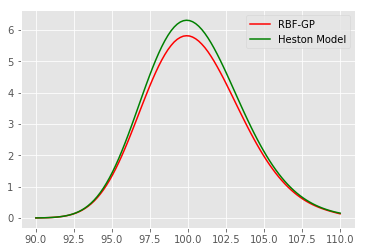

In [546]:
plt.figure(facecolor='white', edgecolor='black')
plt.plot(test_x, predict_mean, color = 'red', label = 'RBF-GP')
plt.plot(test_x, test_y, color = 'green', label = 'Heston Model')
plt.grid(True)
plt.legend()

In [547]:
np.mean((predict_mean - test_y )**2)

0.06461859769471133

In [442]:
mse.append(np.mean((predict_mean - test_y )**2)) 
mse

[4.2783958338876831,
 0.17255430321600509,
 0.034108076640463968,
 6.4916527575206081e-06]

Text(0,0.5,'MSE')

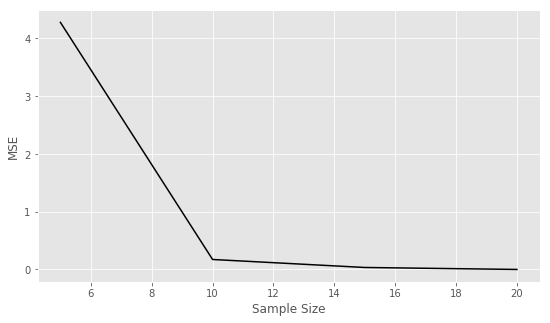

In [446]:
plt.figure(figsize = (9,5),facecolor='white', edgecolor='black')
n_train = np.array([5, 10, 15, 20])  # convergency plot against number of training set
plt.plot(n_train, mse, color='black') 
plt.grid(True)
plt.xlabel('Sample Size')
plt.ylabel('MSE')

With optimization of noise term and lengthscale, we can obtain much better prediction and smaller MSE even with small number of training data.
Compare with convergence test with optimization, it takes around 250 training data without optimization to achieve same prediction power of 10 training data with optimization. 

Text(0,0.5,'MSE')

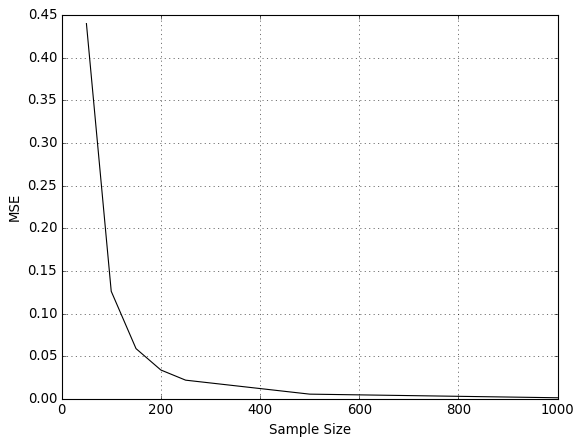

In [571]:
# Convergence test without optimizaiton.
plt.figure(facecolor='white', edgecolor='black')
n_training = np.array([50, 100, 150, 200, 250, 500, 1000])   # convergency plot against number of training set
plt.plot(n_training, mse, color='black') 
plt.grid(True)
plt.xlabel('Sample Size')
plt.ylabel('MSE')

In [227]:
def converge(n_train):
    mse = []
    for n in n_train:
        training_x = np.linspace(90,110, n)
        training_y = []
        for S in training_x:
            training_y.append(HestonVega(S,K,T,r,sigma,lmbda,meanV,v0,rho, 'C', N=nInt))
        
        testing_x = np.linspace(95,105, n)
        testing_y = []
        for S in testing_x:
            testing_y.append(HestonVega(S,K,T,r,sigma,lmbda,meanV,v0,rho, 'C', N=nInt))
            
        train32_x = np.array(training_x, dtype='float32').reshape(n,1)
        test32_x = np.array(testing_x, dtype='float32').reshape(n,1)
        Ker = rbf(train32_x).eval()
        K_noise = Ker+ np.eye(n_train) # *0.1
        k_s = rbf(test32_x, train32_x).eval()                   
        L = np.linalg.cholesky(K_noise)
        alpha = np.linalg.solve(L.T, np.linalg.solve(L, training_y))
        predict_mean = np.dot(k_s, alpha)
        
        mse.append(np.mean((predict_mean - testing_y )**2))
    
    return mse

# Using sklearn

In [549]:
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, RBF

In [743]:
para=[]
error = []

In [793]:
# everytime before change training_number, has to rerun this code, maybe some parameters have been changed when fitting GP by sklearn.
nInt = 256
r0 = 0.0002
S= 100
K = 100
T = 0.01
r = r0
sigma = 0.6
lmbda = 0.1
meanV = 0.1
v0 = 0.1
rho =-0.9
V= HestonCOS(S,K,T,r,sigma,lmbda,meanV,v0,rho, 'C', N=nInt)

vegas = []
S_arr = np.arange(90,110,0.1)
for S in S_arr:
  vegas.append(HestonVega(S,K,T,r,sigma,lmbda,meanV,v0,rho, 'C', N=nInt));

In [794]:
training_number = 2000  # change training size 
train_x = np.array(np.linspace(90,110, training_number), dtype='float32').reshape(training_number, 1)
train_y = []
for S in train_x:
    train_y.append(HestonVega(S,K,T,r,sigma,lmbda,meanV,v0,rho, 'C', N=nInt))
    
testing_number = 100
test_x = np.array(np.linspace(90,110, testing_number), dtype='float32').reshape(testing_number, 1)
test_y = []
for S in test_x:
    test_y.append(HestonVega(S,K,T,r,sigma,lmbda,meanV,v0,rho, 'C', N=nInt))

In [795]:
sk_kernel = ConstantKernel() + RBF(length_scale=1.0, length_scale_bounds=(1e-05, 100000.0)) + WhiteKernel(noise_level=1)
gp = gaussian_process.GaussianProcessRegressor(kernel=sk_kernel)
gp.fit(train_x,train_y)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=1**2 + RBF(length_scale=1) + WhiteKernel(noise_level=1),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

In [796]:
para.append(gp.kernel_)
para

[1.61**2 + RBF(length_scale=3.39) + WhiteKernel(noise_level=1e-05),
 1.49**2 + RBF(length_scale=3.58) + WhiteKernel(noise_level=1e-05),
 1.44**2 + RBF(length_scale=3.59) + WhiteKernel(noise_level=1e-05),
 1.42**2 + RBF(length_scale=3.6) + WhiteKernel(noise_level=1e-05),
 1.4**2 + RBF(length_scale=3.6) + WhiteKernel(noise_level=1e-05),
 1.38**2 + RBF(length_scale=3.61) + WhiteKernel(noise_level=1e-05),
 1.37**2 + RBF(length_scale=3.62) + WhiteKernel(noise_level=1e-05),
 1.35**2 + RBF(length_scale=3.63) + WhiteKernel(noise_level=1e-05)]

In [797]:
y_pred, sigma = gp.predict(test_x, return_std=True)
error.append(np.mean((y_pred - test_y)**2))
error

[4.9857347819245774e-06,
 2.7197769667541691e-07,
 8.9781692404146945e-08,
 4.3606204318066204e-08,
 1.9946063100786997e-08,
 6.3609509516202491e-09,
 2.613768799176132e-09,
 1.0857262003577219e-09]

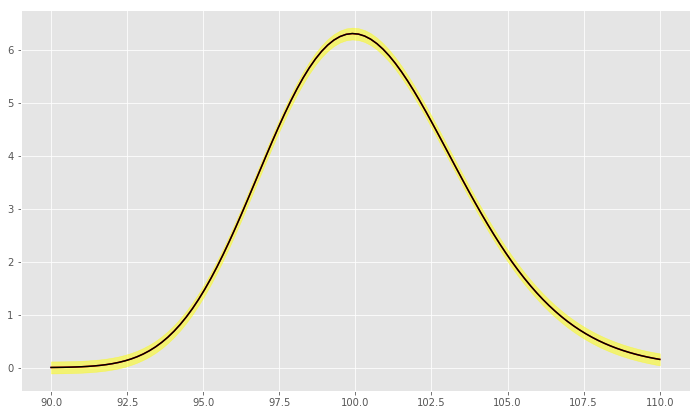

In [798]:
plt.figure(figsize = (12, 7), facecolor='white', edgecolor='black')
plt.plot(test_x.flatten(), y_pred, color = 'red')
plt.plot(test_x.flatten(), test_y, color = 'black')
#plt.scatter(train_x, train_y, color = 'green') 
plt.fill_between(test_x.flatten(), (y_pred-2*np.sqrt(sigma)), (y_pred+2*np.sqrt(sigma)), color = 'yellow', alpha=0.5)

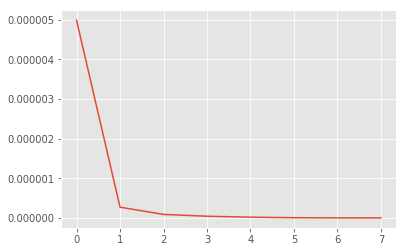

In [801]:
size = np.array([10, 20, 50, 100, 200, 500, 1000, 2000])
plt.plot(error)